In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train.csv', 'sample_submission.csv']


In [2]:
import tqdm
import glob
from fastai.tabular import *

In [3]:
seed = 2019

# python RNG
random.seed(seed)

# pytorch RNGs
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
np.random.seed(seed)

In [4]:
def gen_features(X):
    strain = []
    strain.append(X.mean()) #0
    strain.append(X.std()) #1
    strain.append(X.min()) #2
    strain.append(X.max()) #3
    strain.append(X.kurtosis()) #4
    strain.append(X.skew()) #5
    strain.append(np.quantile(X,0.01)) #6
    strain.append(np.quantile(X,0.05)) #7
#     strain.append(np.quantile(X,0.10)) #8
#     strain.append(np.quantile(X,0.90)) #9
    strain.append(np.quantile(X,0.95)) #10
    strain.append(np.quantile(X,0.99)) #11
    strain.append(np.abs(X).max()) #12
    strain.append(np.abs(X).mean()) #13
    strain.append(np.abs(X).std()) #14
    strain.append(np.square(X).kurtosis()) #15
    strain.append(X.mad()) #16
    return pd.Series(strain)

In [5]:
train = pd.read_csv('../input/train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

train_df = pd.DataFrame()
y_train = pd.Series()
for df in tqdm.tqdm_notebook(train):
    ch = gen_features(df['acoustic_data'])
    train_df = train_df.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]),ignore_index=True)

In [6]:
train_df['time_to_failure'] = y_train

In [7]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,time_to_failure
0,4.884113,5.101106,-98.0,104.0,33.662481,-0.024061,-8.0,-2.0,11.0,18.0,104.0,5.576567,4.333325,1111.171375,3.263401,1.430797
1,4.725767,6.588824,-154.0,181.0,98.758517,0.390561,-11.0,-2.0,12.0,21.0,181.0,5.734167,5.732777,1591.567111,3.574302,1.391499
2,4.906393,6.967397,-106.0,140.0,33.555211,0.217391,-15.0,-3.0,13.0,26.0,140.0,6.152647,5.895945,643.756238,3.948411,1.353196
3,4.902240,6.922305,-199.0,197.0,116.548172,0.757278,-12.0,-2.0,12.0,22.0,199.0,5.933960,6.061214,1797.082229,3.647117,1.313798
4,4.908720,7.301110,-126.0,145.0,52.977905,0.064531,-15.0,-2.0,12.0,26.0,145.0,6.110587,6.329485,695.744438,3.826052,1.274400


In [8]:
X_test = pd.DataFrame()
seg_ids = []
for segs in tqdm.tqdm_notebook(sorted(glob.glob('../input/test/seg_*'))):
    seg_name = segs[segs.rfind('/')+1:segs.rfind('.')]
    sub = pd.read_csv(segs,iterator=True,dtype={'acoustic_data': np.int16})
    for df in sub:
        ch = gen_features(df['acoustic_data'])
        X_test = X_test.append(ch, ignore_index=True)
    seg_ids.append(seg_name)

In [9]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,4.491780,4.893690,-75.0,115.0,28.837568,0.327908,-8.0,-2.0,11.0,18.0,115.0,5.224607,4.102161,2375.162944,3.248521
1,4.171153,5.922839,-140.0,152.0,56.218955,0.295708,-12.0,-2.0,11.0,20.0,152.0,5.198340,5.045369,1955.044737,3.429208
2,4.610260,6.946990,-193.0,248.0,162.118284,0.428688,-11.0,-2.0,11.0,20.0,248.0,5.597193,6.179525,1606.461297,3.461984
3,4.531473,4.114147,-93.0,85.0,41.241827,0.061889,-5.0,-1.0,10.0,14.0,93.0,4.961487,3.583863,1253.910000,2.678503
4,4.128340,5.797164,-147.0,177.0,79.539708,0.073898,-10.0,-2.0,10.0,19.0,177.0,5.070900,4.993617,2795.248550,3.283856


In [10]:
procs = [Normalize]
cont_vars = [x for x in range(train_df.shape[1]-1)]

In [90]:
data = (TabularList.from_df(train_df,procs=procs,cont_names=cont_vars)
                .split_by_rand_pct(0.01)
                .label_from_df(cols='time_to_failure')
                .add_test(TabularList.from_df(X_test))
                .databunch())

In [91]:
len(data.train_ds.cont_names)

15

In [92]:
class SmoothL1LossFlat(nn.SmoothL1Loss):
    def forward(self, input:Tensor, target:Tensor) -> Rank0Tensor:
        return super().forward(input.view(-1), target.view(-1))

In [98]:
learn = tabular_learner(data, layers=[1024,512], ps=[0.07,0.7], emb_drop=0.7,metrics=[mean_absolute_error])

In [99]:
learn.loss_func = SmoothL1LossFlat()

In [100]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.7)
  (bn_cont): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=1024, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.07)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.7)
    (8): Linear(in_features=512, out_features=1, bias=True)
  )
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


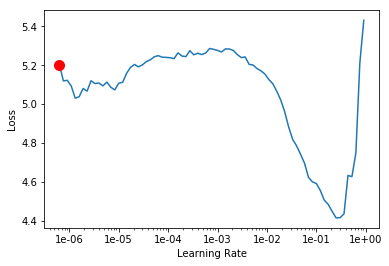

In [101]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [102]:
learn.fit_one_cycle(10, 2e-2, wd=0.2)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,3.773748,1.644148,2.102905,00:01
1,2.347727,1.899246,2.376062,00:01
2,2.019687,2.072341,2.525737,00:01
3,1.853202,1.905922,2.359099,00:01
4,1.824795,2.283046,2.758467,00:01
5,1.766400,1.917797,2.379342,00:01
6,1.745857,1.894257,2.351234,00:01
7,1.735505,1.843065,2.310651,00:01
8,1.710064,1.877511,2.339326,00:01
9,1.688989,1.823134,2.281589,00:01


In [20]:
test_preds=learn.get_preds(ds_type=DatasetType.Test)

In [21]:
sub_csv = pd.read_csv('../input/sample_submission.csv')

In [22]:
sub_csv.head()

,seg_id,time_to_failure
0,seg_00030f,0
1,seg_0012b5,0
2,seg_00184e,0
3,seg_003339,0
4,seg_0042cc,0


In [23]:
sub_csv['time_to_failure'] = test_preds[0].numpy()

In [26]:
sub_csv.to_csv('submission.csv',index=False)